In [2]:
%load_ext autoreload 
%autoreload 2

import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(os.path.join(os.getcwd(), ".."))

import math
import numpy as np
import pandas as pd
from numpy import array
from numpy import array, arange, abs as np_abs
from numpy.fft import rfft, rfftfreq
from math import sin, pi
from scipy import signal
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import random

import importlib
import model as md
import view as vw

importlib.reload(md)
importlib.reload(vw)

c:\Users\Артем\Desktop\Вуз\Аспирантура\Диссертация\Алгоритм\Relaxation_frequency_phase_algorithm\notebooks\Solo_ms\..


<module 'view' from 'c:\\Users\\Артем\\Desktop\\Вуз\\Аспирантура\\Диссертация\\Алгоритм\\Relaxation_frequency_phase_algorithm\\view\\__init__.py'>

In [5]:
from SALib.sample import morris as morris_sampler
from SALib.analyze import morris as morris_analyzer

phase_method=md.get_phase_maxpoint_diff

# 1) Определяем параметры
problem = {
    'num_vars': 5,
    'names': ['F', 'fs_mult', 'duration_T','phase','SNR'],
    'bounds': [
        [300e3, 500e3],     # F
        [3, 20],            # fs_mult
        [3, 200],           # duration_T
        [1,179],             # phase
        [20,60]             # SNR
    ]
}

# 2) Генерация траекторий
param_values = morris_sampler.sample(problem, N=2000, num_levels=10)

# 3) Модель
Y = []
for p in param_values:
    F, fs_mult, duration_T, phase_real, SNR  = p

    duration=duration_T/F
    t = np.arange(0, duration, 1/(fs_mult*F))
    U = md.generate_sin(t,F,2)
    I = md.generate_sin(t,F,2,phase_real)

    # --- Добавление шума ---
    noise_power = np.mean(U**2) / (10**(SNR / 10))
    noise = np.sqrt(noise_power) * np.random.randn(len(U))
    U += noise
    I += noise

    time, phase_mes=phase_method(t,U,I,F)
    phase_kde=md.get_kde_mode(phase_mes)

    phase_error=abs(phase_kde) - abs(phase_real)
    Y.append(abs(phase_error))

Y=np.array(Y)

print(Y[-1])
print(p)


13.678417620464288
[3.66666667e+05 3.00000000e+00 1.78111111e+02 8.01111111e+01
 2.88888889e+01]


In [7]:
Si = morris_analyzer.analyze(problem, param_values, Y, print_to_console=True)

                  mu   mu_star     sigma  mu_star_conf
F          -0.011001  0.757477  1.823934      0.072563
fs_mult    -2.637993  4.037811  8.307442      0.324053
duration_T -0.350956  0.827892  1.963227      0.079464
phase      -0.221258  1.952347  4.680793      0.184198
SNR        -1.543505  1.748720  3.153005      0.142987


100
200
300
400
500
600
1000
1200
1600
2000


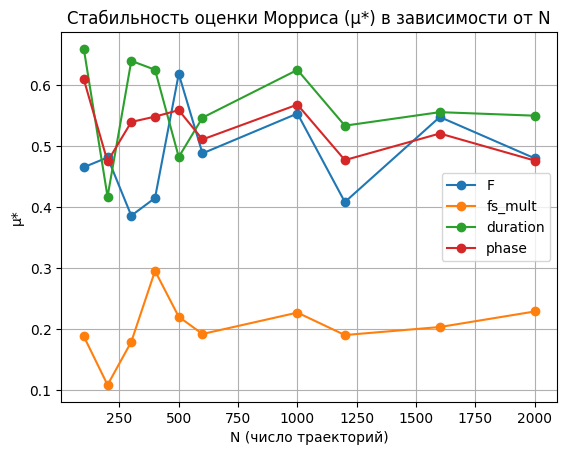

In [7]:
from SALib.sample import morris as morris_sampler
from SALib.analyze import morris as morris_analyzer
import numpy as np
import matplotlib.pyplot as plt

# --- Используем твой метод
phase_method = md.get_phase_hilbert

# 1) Конфигурация параметров
problem = {
    'num_vars': 4,
    'names': ['F', 'fs_mult', 'duration', 'phase'],
    'bounds': [
        [300e3, 500e3],
        [3, 50],
        [3e-6, 200e-6],
        [0, 180]
    ]
}

# 2) Значения N для тестирования стабильности
test_N = [100, 200, 300, 400, 500, 600, 1000, 1200,1600, 2000]
mu_star_by_N = {name: [] for name in problem['names']}

# 3) Цикл по N
for N in test_N:
    print(N)
    param_values = morris_sampler.sample(problem, N=N, num_levels=10)
    Y = []

    for p in param_values:
        F, fs_mult, duration, phase = p

        t = np.arange(0, duration, 1/(fs_mult * F))
        U = md.generate_sin(t, F, 2)
        I = md.generate_sin(t, F, 2, phase)

        _, phase_vals = phase_method(t, U, I, F)
        phase_kde = md.get_kde_mode(phase_vals)

        Y.append((phase_kde - phase + 180) % 360 - 180)

    Y=np.array(Y)

    Si = morris_analyzer.analyze(problem, param_values, Y)

    for name, val in zip(problem['names'], Si['mu_star']):
        mu_star_by_N[name].append(val)

# --- Построение графика
plt.figure()
for name in problem['names']:
    plt.plot(test_N, mu_star_by_N[name], marker='o', label=name)

plt.xlabel('N (число траекторий)')
plt.ylabel('μ*')
plt.title('Стабильность оценки Морриса (μ*) в зависимости от N')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
Si = morris_analyzer.analyze(problem, param_values, Y, print_to_console=True)

                mu   mu_star     sigma  mu_star_conf
F        -0.143454  0.484707  1.843304      0.074062
fs_mult  -0.137173  0.252419  1.371758      0.053991
duration  0.331686  0.610939  1.826139      0.063961
phase     0.140354  0.497183  1.766280      0.073239
